In [7]:
"""
load data
"""
import sklearn.datasets
import numpy as np
import random

iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_matrix(x, y, group, fmt='.', **kwargs):
    """
    Given two d-dimensional datasets of n points,
    makes a figure containing d x d plots, where the (i, j) plot
    plots the ith dimension against the jth dimension.
    """

    x = np.asarray(x)
    y = np.asarray(y)
    group = np.squeeze(np.asarray(group))
    n, p = x.shape
    n_, q = y.shape
    n__, = group.shape
    assert n == n_ == n__
    groups = sorted(set(group))
    if isinstance(fmt, str):
        fmt = {k: fmt for k in groups}
    fig, axes = plt.subplots(p, q, squeeze=False, **kwargs)
    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            for g in groups:
                ax.plot(x[group == g, i], y[group == g, j], fmt[g])
            if len(axes) > 2:
                ax.locator_params(tight=True, nbins=4)

def plot_groups(x, group, fmt='.', **kwargs):
    """
    Helper function for plotting a 2-dimensional dataset with groups
    using plot_matrix.
    """
    n, d = x.shape
    assert d == 2
    x1 = x[:, 0].reshape(n, 1)
    x2 = x[:, 1].reshape(n, 1)
    plot_matrix(x1, x2, group, fmt, **kwargs)

In [15]:
def closest(data, centers):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    
    rep = np.zeros(n,)
    for i in range(n):
        distance = np.sum(np.sqrt((data[i] - centers)**2), axis = 1)
        rep[i] = np.argmin(distance)
        
    assert rep.shape == (n,)
    assert np.all((0 <= rep) & (rep < k))
    rep = rep.astype('int')
    return rep


def kmeans_cost(data, centers, rep):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    assert rep.shape == (n,)
    data_rep = centers[rep]
    cost = 0
    for i in range(n):
        cost += np.sum((data[i] - data_rep[i])**2)
    return cost

"""
K-means clustering algorithm
args:
D = dataset
k = number of clusters
epsilon = convergence threshold
"""

def k_means(D, k, epsilon, verbose = True):
    n,d = D.shape
    """
    init random centroids
    centroids is a k,d array where element i,j is the jth value of the ith centroid
    assign each data point to a closest centroid
    recaulculate clusters as mean of all elements in cluster
    if cluster is empty, reassign randomly.
    calculate distance between new and old clusters
    if distance is smaller than epsilon, terminate
    """
    maximum = np.amax(D, axis = 0)
    minimum = np.amin(D, axis = 0)
    centers = np.zeros((k,d))
    for i in range(len(centers)):
        for j in range(d):
            centers[i,j] = random.uniform(minimum[j], maximum[j])
    old_centers = np.zeros_like(centers)
    tired = False
    
    while not tired:
        old_centers[:] = centers
        rep = closest(D, centers)
        for i in range(k):
            indices = np.where(rep == i)[0]
            if len(indices) == 0:
                   for j in range(d):
                       print('tom')
                       centers[i,j] = random.uniform(minimum[j], maximum[j])
            else:
                centers[i] = np.sum(D[indices], axis = 0)/len(indices)
            
        dist = np.sqrt(((centers - old_centers) ** 2).sum(axis=1))
        tired = np.max(dist) <= epsilon
        cost = kmeans_cost(D, centers, rep)
        if verbose == True:
            print(cost)
    return centers, rep, cost

def k_means_opt(D, k, epsilon, n):
    centers = []
    rep = []
    cost = []
    for i in range(n):
        res = k_means(D, k, epsilon, verbose = False)
        centers.append(res[0])
        rep.append(res[1])
        cost.append(res[2])
    j = np.argmin(cost)
    return centers[j], rep[j], cost[j]

In [43]:
data_2d = data[:, 1:3]
#centers, rep, cost = k_means_opt(data_2d, 3, 1e-4, 50)

centers, rep, cost = k_means(data_2d, 3, 1e-3)

97.7071302178
59.6898050656
44.4346494325
43.5710256304
42.7347971014
41.8794
41.6635242874
41.9343284374
41.5894269294
41.522989071
41.522989071


[[ 3.418       1.464     ]
 [ 2.7442623   4.38196721]
 [ 3.07179487  5.72564103]]


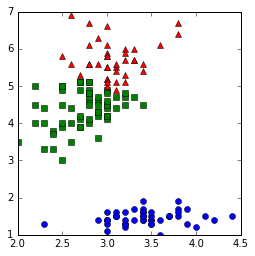

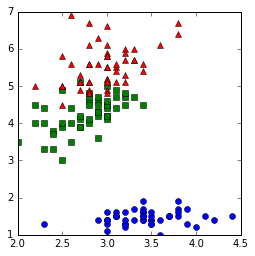

In [44]:
print(centers)
plot_groups(data_2d, rep, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))
plot_groups(data_2d, labels, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))
